In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('C:/develop/Fishing_team/data/processed_data.csv')

In [8]:
if 'datetime' in df.columns:
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['day_of_week'] = pd.to_datetime(df['datetime']).dt.dayofweek
else:
    print("Столбец 'datetime' не найден. Пожалуйста, проверьте исходные данные.")

In [9]:
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
print(f"Столбцы с нечисловыми данными: {non_numeric_columns}")

Столбцы с нечисловыми данными: Index(['ip', 'device_type', 'card_type', 'card_status', 'expiration_date',
       'datetime', 'oper_type'],
      dtype='object')


In [10]:
categorical_columns = ['device_type', 'tran_code', 'mcc', 'card_type', 'oper_type'] 
le = LabelEncoder()

In [11]:
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

In [12]:
numeric_columns = ['pin_inc_count', 'balance', 'sum', 'hour', 'day_of_week']

In [13]:
numeric_columns = [col for col in numeric_columns if col not in non_numeric_columns]

In [14]:
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

In [15]:
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

In [16]:
features = df[numeric_columns]

In [17]:
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)

df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

In [18]:
print(f"Количество аномальных транзакций: {df['anomaly'].sum()}")
print(f"Процент аномальных транзакций: {df['anomaly'].mean() * 100:.2f}%")

Количество аномальных транзакций: 2654
Процент аномальных транзакций: 5.00%


# Визуализация результатов

In [19]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features)

In [20]:
df['pca1'] = pca_components[:, 0]
df['pca2'] = pca_components[:, 1]

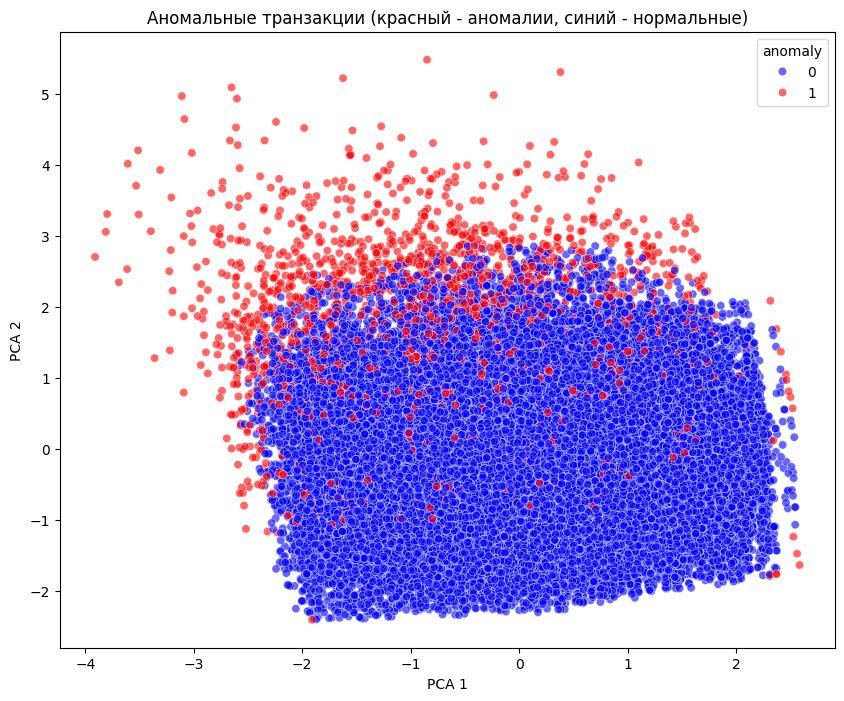

In [21]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='anomaly', data=df, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("Аномальные транзакции (красный - аномалии, синий - нормальные)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [22]:
anomalies = df[df['anomaly'] == 1]
print("Аномальные транзакции:")
print(anomalies)

Аномальные транзакции:
       Unnamed: 0  transaction_id             ip  device_id  device_type  \
41             41         8944583    91.107.0.90      982.0            3   
65             65         3341230  109.126.0.225      384.0            3   
73             73         4695142  194.156.0.195       37.0            3   
88             88         8361043    46.0.54.225     1092.0            1   
95             95         9347352   46.0.176.240      135.0            2   
...           ...             ...            ...        ...          ...   
52970       52970         9883321     2.94.0.225     1472.0            0   
52983       52983         9901279    128.0.81.30     1290.0            0   
52997       52997         9728378    46.0.42.120     1494.0            0   
53024       53024         9913087    85.21.0.105      272.0            0   
53065       53065         9847180   82.200.0.195      624.0            0   

       tran_code   mcc  client_id  card_type  pin_inc_count  ...